In [1]:
# dataframe and plotting
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# machine learning
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import warnings
warnings.filterwarnings('ignore')

C:\ProgramData\anaconda3\lib\site-packages\dask\dataframe\_pyarrow_compat.py:23: UserWarning: You are using pyarrow version 11.0.0 which is known to be insecure. See https://www.cve.org/CVERecord?id=CVE-2023-47248 for further details. Please upgrade to pyarrow>=14.0.1 or install pyarrow-hotfix to patch your current version.
  warnings.warn(


In [2]:
# Load files into a pandas dataframe
train = pd.read_csv('D:\\ML PROJECTS\\financial-inclusion-in-africa\\Train.csv')
test = pd.read_csv('D:\\ML PROJECTS\\financial-inclusion-in-africa\\Test.csv')
ss = pd.read_csv('D:\\ML PROJECTS\\financial-inclusion-in-africa\\SampleSubmission.csv')
variables = pd.read_csv('D:\\ML PROJECTS\\financial-inclusion-in-africa\\VariableDefinitions.csv')

In [3]:
# Let’s observe the shape of our datasets.
print('train data shape :', train.shape)
print('test data shape :', test.shape)

train data shape : (23524, 13)
test data shape : (10086, 12)


In [4]:
# inspect train data
train.head()

,country,year,uniqueid,bank_account,location_type,cellphone_access,household_size,age_of_respondent,gender_of_respondent,relationship_with_head,marital_status,education_level,job_type
0,Kenya,2018,uniqueid_1,Yes,Rural,Yes,3,24,Female,Spouse,Married/Living together,Secondary education,Self employed
1,Kenya,2018,uniqueid_2,No,Rural,No,5,70,Female,Head of Household,Widowed,No formal education,Government Dependent
2,Kenya,2018,uniqueid_3,Yes,Urban,Yes,5,26,Male,Other relative,Single/Never Married,Vocational/Specialised training,Self employed
3,Kenya,2018,uniqueid_4,No,Rural,Yes,5,34,Female,Head of Household,Married/Living together,Primary education,Formally employed Private
4,Kenya,2018,uniqueid_5,No,Urban,No,8,26,Male,Child,Single/Never Married,Primary education,Informally employed


In [5]:
# Check for missing values
print('missing values:', train.isnull().sum())

missing values: country                   0
year                      0
uniqueid                  0
bank_account              0
location_type             0
cellphone_access          0
household_size            0
age_of_respondent         0
gender_of_respondent      0
relationship_with_head    0
marital_status            0
education_level           0
job_type                  0
dtype: int64


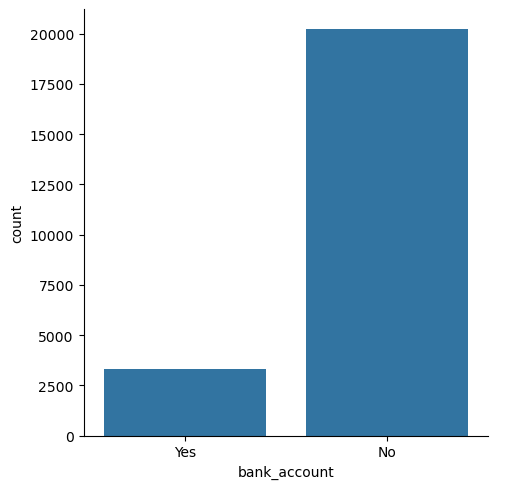

In [6]:
# Explore Target distribution 
sns.catplot(x="bank_account", kind="count", data=train)

In [7]:
# view the submission file
ss.head()

,unique_id,bank_account
0,uniqueid_1 x Kenya,0
1,uniqueid_2 x Kenya,0
2,uniqueid_3 x Kenya,0
3,uniqueid_4 x Kenya,0
4,uniqueid_5 x Kenya,0


In [8]:
 #show some information about the dataset
 print(train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23524 entries, 0 to 23523
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   country                 23524 non-null  object
 1   year                    23524 non-null  int64 
 2   uniqueid                23524 non-null  object
 3   bank_account            23524 non-null  object
 4   location_type           23524 non-null  object
 5   cellphone_access        23524 non-null  object
 6   household_size          23524 non-null  int64 
 7   age_of_respondent       23524 non-null  int64 
 8   gender_of_respondent    23524 non-null  object
 9   relationship_with_head  23524 non-null  object
 10  marital_status          23524 non-null  object
 11  education_level         23524 non-null  object
 12  job_type                23524 non-null  object
dtypes: int64(3), object(10)
memory usage: 2.3+ MB
None


In [9]:
# Let's view the variables
variables

,Variable Definitions,Unnamed: 1
0,country,Country interviewee is in.
1,year,Year survey was done in.
2,uniqueid,Unique identifier for each interviewee
3,location_type,"Type of location: Rural, Urban"
4,cellphone_access,"If interviewee has access to a cellphone: Yes, No"
5,household_size,Number of people living in one house
6,age_of_respondent,The age of the interviewee
7,gender_of_respondent,"Gender of interviewee: Male, Female"
8,relationship_with_head,The interviewee’s relationship with the head o...
9,marital_status,The martial status of the interviewee: Married...


In [10]:
#import preprocessing module
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

# Convert target label to numerical Data
le = LabelEncoder()
train['bank_account'] = le.fit_transform(train['bank_account'])

#Separate training features from target
X_train = train.drop(['bank_account'], axis=1)
y_train = train['bank_account']

print(y_train)

0        1
1        0
2        1
3        0
4        0
        ..
23519    0
23520    0
23521    0
23522    0
23523    0
Name: bank_account, Length: 23524, dtype: int32


In [11]:
# function to preprocess our data from train models
def preprocessing_data(data):

    # Convert the following numerical labels from interger to float
    float_array = data[["household_size", "age_of_respondent", "year"]].values.astype(float)
    
    # categorical features to be converted to One Hot Encoding
    categ = ["relationship_with_head",
             "marital_status",
             "education_level",
             "job_type",
             "country"]
    
    # One Hot Encoding conversion
    data = pd.get_dummies(data, prefix_sep="_", columns=categ)
    
    # Label Encoder conversion
    data["location_type"] = le.fit_transform(data["location_type"])
    data["cellphone_access"] = le.fit_transform(data["cellphone_access"])
    data["gender_of_respondent"] = le.fit_transform(data["gender_of_respondent"])
    
    # drop uniquid column
    data = data.drop(["uniqueid"], axis=1)
    
    # scale our data into range of 0 and 1
    scaler = MinMaxScaler(feature_range=(0, 1))
    data = scaler.fit_transform(data)
    
    return data                  

In [12]:
# preprocess the train data 
processed_train = preprocessing_data(X_train)
processed_test = preprocessing_data(test)

In [13]:
# the first train row
print(processed_train[:1])

[[1.        0.        1.        0.1       0.0952381 0.        0.
  0.        0.        0.        0.        1.        0.        0.
  1.        0.        0.        0.        0.        0.        1.
  0.        0.        0.        0.        0.        0.        0.
  0.        0.        0.        0.        1.        1.        0.
  0.        0.       ]]


In [14]:
# shape of the processed train set
print(processed_train.shape)

(23524, 37)


In [15]:
import sklearn.model_selection

In [16]:
# Split train_data
from sklearn.model_selection import train_test_split

X_Train, X_Val, y_Train, y_val = train_test_split(processed_train, y_train, stratify = y_train, 
                                                  test_size = 0.1, random_state=42)

In [17]:
#import classifier algorithm here
from xgboost import XGBClassifier

# create models
xg_model = XGBClassifier()

#fitting the models
xg_model.fit(X_Train,y_Train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [18]:
# import evaluation metrics
from sklearn.metrics import confusion_matrix, accuracy_score

# evaluate the model
xg_y_model = xg_model.predict(X_Val)

# Get error rate
print("Error rate of XGB classifier: ", 1 - accuracy_score(y_val, xg_y_model))

Error rate of XGB classifier:  0.11177220569485757


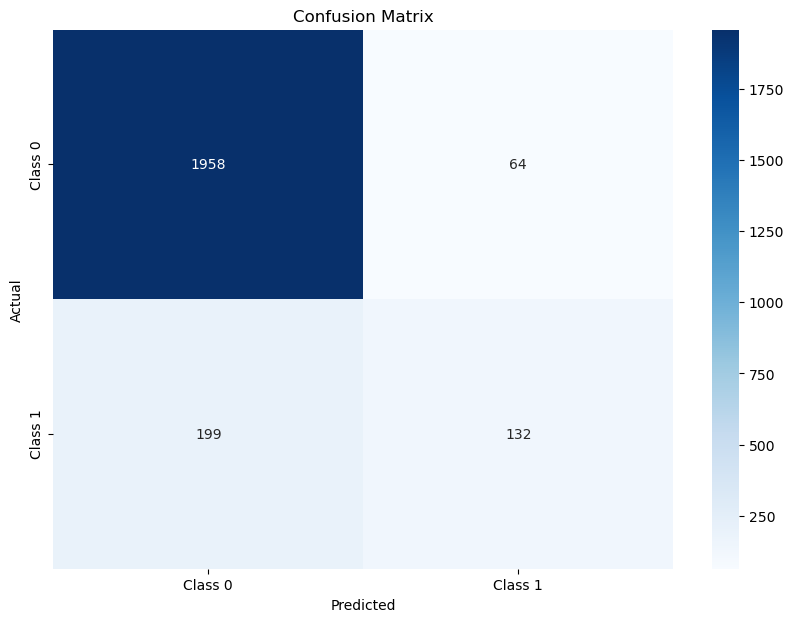

In [19]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Compute confusion matrix
cm = confusion_matrix(y_val, xg_model.predict(X_Val))

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Class 0', 'Class 1'],
            yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Import GridSearchCV
from sklearn.model_selection import GridSearchCV

# Optimize model parameters
# I run this code in google colab to make the execution much faster and use the best params in the next code
param_grid = {'min_child_weighth': [1, 5, 10],
        'gamma': [0.5, 1],
        'subsample': [0.6, 0.8, 1.0],
        'max_depth': [3, 5]
        }
my_xgb_model = GridSearchCV(xg_model, param_grid,n_jobs=-1,verbose=2,cv=5)
my_xgb_model.fit(X_Train, y_Train)
print(my_xgb_model.best_params_)        

Fitting 5 folds for each of 36 candidates, totalling 180 fits


In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score

# fit by setting best parameters and Evaluate model
xgb_model = XGBClassifier(min_child_weight=1, gamma=1, subsample=0.8, max_depth=5)

xgb_model.fit(X_Train, y_Train)
y_pred = xgb_model.predict(X_Val)

# Get error rate
print("Error rate of the XGB classifier: ", 1 - accuracy_score(y_val, y_pred))

In [ ]:
# Get the predicted result for the test Data
test.bank_account = xgb_model.predict(processed_test)

In [ ]:
# Create submission DataFrame
submission = pd.DataFrame({"uniqueid": test["uniqueid"] + " x " + test["country"],
                           "bank_account": test.bank_account})

In [ ]:
#show the five sample
submission.sample(5)

In [ ]:
submission.to_csv('third_submission.csv', index=False)

In [ ]:
from IPython.display import FileLink

# Create a link to download the CSV file
FileLink('third_submission.csv')